## Observations and Insights 

In [44]:
# !pip install -U scikit-learn
# !python -m pip show scikit-learn  # to see which version and where scikit-learn is installed
# !python -m pip freeze  # to see all packages installed in the active virtualenv
# !python -c "import sklearn; sklearn.show_versions()"

In [160]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
from scipy.stats import sem
import numpy as np

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
# merged_df = pd.merge(mouse_metadata, study_results, on="Mouse ID", suffixes=("_Bitcoin", "_Dash"))
merged_df = pd.merge(mouse_metadata, study_results, on="Mouse ID")

# Display the data table for preview
merged_df

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [46]:
# Checking the number of mice.
mice_count = merged_df['Mouse ID'].value_counts().to_frame()
mice_count

,Mouse ID
g989,13
b742,10
i177,10
m269,10
o331,10
...,...
x226,1
v199,1
t573,1
u153,1


In [47]:
# Checking the number of mice.
mice_count2 = merged_df['Mouse ID'].nunique()
mice_count2

249

In [48]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicates_bool = merged_df.duplicated(subset=['Mouse ID','Timepoint'])
duplicates = merged_df.loc[duplicates_bool==True]
duplicates

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [100]:
# Optional: Get all the data for the duplicate mouse ID. 
duplicate_info = merged_df[merged_df.duplicated()]
duplicate_info = duplicate_info.rename(columns={'Mouse ID':'Mouse_ID'})
duplicate_info.Mouse_ID

909    g989
Name: Mouse_ID, dtype: object

In [102]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
clean_df = merged_df.rename(columns={'Mouse ID':'Mouse_ID',
                                     'Tumor Volume (mm3)':'Tumor_Volume_mm3',
                                     'Drug Regimen':'Drug_Regimen'})
clean_df = clean_df[clean_df.Mouse_ID != 'g989']
# clean_df = clean_df[clean_df.Mouse_ID != duplicate_info.Mouse_ID.iloc[1]]
clean_df

,Mouse_ID,Drug_Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor_Volume_mm3,Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [103]:
# Checking the number of mice in the clean DataFrame.
mice_count3 = clean_df['Mouse_ID'].nunique()
mice_count3

248

## Summary Statistics

In [158]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and 
# SEM of the tumor volume for each regimen
drugreg_df = clean_df.groupby('Drug_Regimen')
drugreg_tv_df = drugreg_df['Tumor_Volume_mm3']
drugreg_tv_mean = drugreg_tv_df.mean()
drugreg_tv_median = drugreg_tv_df.median()
drugreg_tv_var = drugreg_tv_df.var()
drugreg_tv_std = drugreg_tv_df.std()


# Calculate means
sems_list = []
drug_list = []
# sems_df = pd.DataFrame()
# for y in range(len(drugreg_tv_df)):
for drug in drugreg_tv_df:
    nsamples = 20
    div = 25
    samples = [clean_df.Tumor_Volume_mm3.sample(div) for x in range(0,nsamples)]
    samples
    means = [sample.mean() for sample in samples]
    # Calculate standard error on means
    sems = [sem(s) for s in samples]
    sems_list.append(min(sems))
    drug_list.append(drug)

drug_df=pd.DataFrame(drug_list)
drug_df=drug_df[0]
# drug_df['SEM']=sems_list.T
drug_df = drug_df.reset_index()
# drug_df
sems_data = pd.DataFrame(sems_list)
sems_data = sems_data.reset_index()
# sems_data
# sems_data = {'Drug_Regimen':drug_list[0],'SEM':sems_list}
# sems_data
sems_df = pd.merge(drug_df,sems_data,on="index")
sems_df = sems_df.rename(columns={'0_x':'Drug_Regimen','0_y':'SEM'})
sems_df = sems_df[['Drug_Regimen','SEM']]
sems_df

# nsamples = 20
# div = 25
# samples = [drugreg_tv_df.sample(div) for x in range(0,nsamples)]
# # samples_frame = pd.DataFrame(samples)
# # samples_frame = samples_frame.reset_index()
# # samples_frame.columns.values[1]="Tumor_Volume_mm3"
# means = [sample.mean() for sample in samples]
# # Calculate standard error on means
# sems = [sem(s) for s in samples]
# sems_df.append({drug:min(sems)})
# sems_list
# drugreg_tv_df.mean()

# drug_names = ['Capomulin','Ceftamin','Infubinol',
#               'Ketapril','Naftisol','Placebo',
#               'Propriva','Ramicane','Stelasyn','Zoniferol']

# sems_data = {'Drug_Regimen':drug_names,'SEM':sems_list}
# sems_df = pd.DataFrame(sems_data,columns=['Drug_Regimen','SEM'])
# sems_df
# test = [{'Capomulin':min(sems),'Ceftamin':2,'Infubinol':3,'Ketapril':4,
#         'Naftisol':5,'Placebo':6,'Propriva':7,'Ramicane':8,
#         'Stelasyn':9,'Zoniferol':10}]
# test_frame = pd.DataFrame(test)

# Determine which sample's mean is closest to the population mean
# print(f"The smallest SEM observed was {min(sems)}")
# samp_index = sems.index(min(sems))
# print(f"The sample with the smallest SEM is sample {samp_index+1}")
# sems_df

# Create summary dataframe
summary_df = pd.DataFrame({'Mean':drugreg_tv_mean,
                           'Median':drugreg_tv_median,
                           'Variance':drugreg_tv_var,
                           'Standard Deviation':drugreg_tv_std                           
                           })
summary_df = summary_df.reset_index()
summary_df = summary_df.rename(columns={'Drug Regimen':'Drug_Regimen'})
# test_frame = test_frame.T
# test_frame = test_frame.reset_index()
# test_frame = test_frame.rename(columns={'index':'Drug_Regimen'})
# test_frame.columns.values[1]="SEM"
merged_df = pd.merge(summary_df,sems_df,on="Drug_Regimen")
index = merged_df.index
index.name="Tumor Volume mm3\
    Summary Statistics by Drug Regimen"
merged_df = merged_df.rename(columns={'Drug_Regimen':'Drug Regimen'})
merged_df
# sems_df = pd.merge(drug_df,sems_data,on="index")

# summary_df
# test_frame

# clean_df


# Use groupby and summary statistical methods to calculate the following properties of each drug regimen: 
# mean, median, variance, standard deviation, and SEM of the tumor volume. 
# Assemble the resulting series into a single summary dataframe.


,Drug Regimen,Mean,Median,Variance,Standard Deviation,SEM
Tumor Volume mm3 Summary Statistics by Drug Regimen,,,,,,
0,Capomulin,40.675741,41.557809,24.947764,4.994774,1.172680
1,Ceftamin,52.591172,51.776157,39.290177,6.268188,1.237601
2,Infubinol,52.884795,51.820584,43.128684,6.567243,1.300828
3,Ketapril,55.235638,53.698743,68.553577,8.279709,1.307477
4,Naftisol,54.331565,52.509285,66.173479,8.134708,1.291505
5,Placebo,54.033581,52.288934,61.168083,7.821003,1.317778
6,Propriva,52.320930,50.446266,43.852013,6.622085,1.097102
7,Ramicane,40.216745,40.673236,23.486704,4.846308,1.363841
8,Stelasyn,54.233149,52.431737,59.450562,7.710419,1.145986


In [159]:
# tv_mean = clean_df.Tumor_Volume_mm3.mean()
# print(tv_mean)
# tv_median = clean_df.Tumor_Volume_mm3.median()
# tv_variance = clean_df.Tumor_Volume_mm3.var()
# tv_std = clean_df.Tumor_Volume_mm3.std()
# # mode_scipy = sts.mode(Tumor_Volume_mm3)
# print(tv_median)
# print(tv_variance)
# print(tv_std)

In [8]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and 
# SEM of the tumor volume for each regimen

# Using the aggregation method, produce the same summary statistics in a single line


## Bar and Pie Charts

<IPython.core.display.Javascript object>


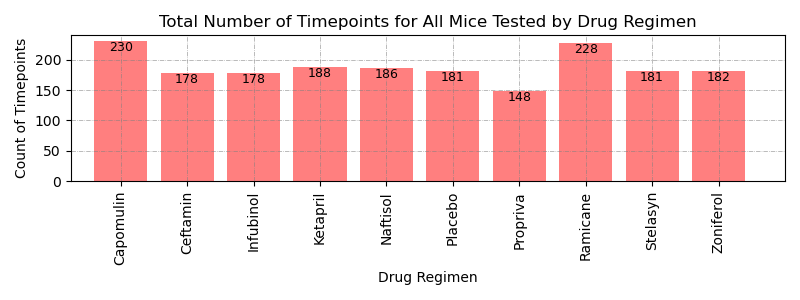

In [224]:
# Generate a bar plot showing the total number of timepoints for all mice tested
# for each drug regimen using Pandas.

%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

timepoint_count = drugreg_tv_df.count()
timepoint_df = pd.DataFrame({'Timepoint_Count':timepoint_count})
timepoint_df = timepoint_df.reset_index()
timepoint_df[['Drug_Regimen','Timepoint_Count']].set_index('Drug_Regimen').plot
# need count of total number of timepoints by drug regimen
x_axis = np.arange(len(timepoint_df))
tick_locations = [value for value in x_axis]
plt.figure(figsize=(8,3))
plt.bar(x_axis, timepoint_df["Timepoint_Count"], color='r', alpha=0.5, align="center")
plt.xticks(tick_locations, timepoint_df["Drug_Regimen"], rotation="vertical")
plt.xlim(-0.75, len(x_axis))
plt.ylim(0, max(timepoint_df["Timepoint_Count"])+10)
plt.title("Total Number of Timepoints for All Mice Tested by Drug Regimen")
plt.xlabel("Drug Regimen")
plt.ylabel("Count of Timepoints")
plt.grid(b=True,color='grey',linestyle='-.',linewidth=0.5,alpha=0.75)
label = timepoint_df['Timepoint_Count']
for i in range(len(timepoint_df)):
    plt.text(x=i,y=label[i],s=label[i],
            size = 9, rotation = 0, color = 'black',
            horizontalalignment = 'center',
            va = 'top')
plt.tight_layout()
plt.show()

In [209]:
len(timepoint_df)

10

<IPython.core.display.Javascript object>


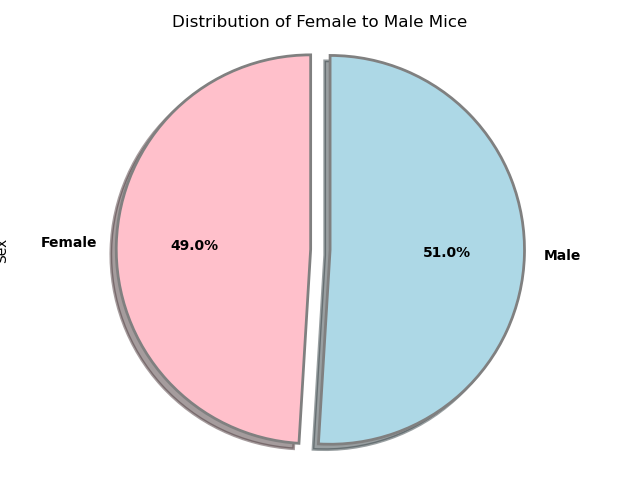

In [197]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

sex_df = clean_df.groupby('Sex')
sex_df2 = sex_df['Sex']
sex_count = sex_df2.count()

sex_pie = sex_count.plot(kind="pie", title=("Distribution of Female to Male Mice"),
                         shadow=True, startangle=90, autopct='%1.1f%%',
                        colors=['pink','lightblue'], explode = [0.05,0.05],
                        wedgeprops={'linewidth':2,'edgecolor':'gray'},
                        textprops = {'weight':'bold'})
plt.tight_layout()
plt.axis("equal")
plt.show()

## Quartiles, Outliers and Boxplots

In [13]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Start by getting the last (greatest) timepoint for each mouse


# Merge this group df with the original dataframe to get the tumor volume at the last timepoint


In [14]:
# Put treatments into a list for for loop (and later for plot labels)


# Create empty list to fill with tumor vol data (for plotting)


# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [15]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [16]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin


In [17]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen


## Correlation and Regression

In [18]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
